# Jenius forecasting - Funded customers <a class="tocSkip">
*Beatriz Bueno Larraz*

Funded customers are the ones having balance larger than Rp10.000. We want to forecast the daily number of funded customers.

In [6]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [3]:
dfp = pd.read_csv("input/Funded_customers.csv", parse_dates=['Date'], thousands=',')
dfp.columns= ['date', 'n_funded_cust', 'daily_change']
dfp.loc[dfp['daily_change']<200, 'daily_change'] = np.nan #Abnormal days are marked as NaN

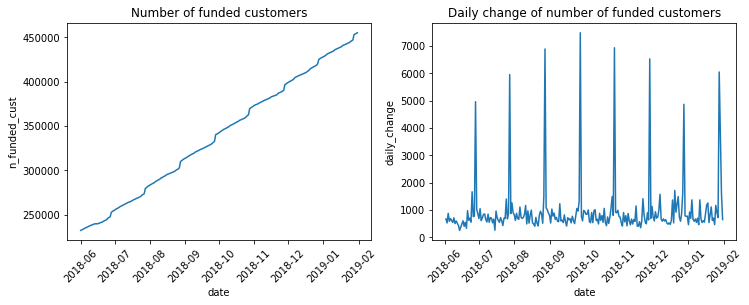

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
ax = sns.lineplot(x=dfp['date'], y=dfp['n_funded_cust'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Number of funded customers')
plt.subplot(1,2,2)
ax = sns.lineplot(x=dfp['date'], y=dfp['daily_change'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Daily change of number of funded customers')
plt.show()

Mark special days:

In [4]:
#Payment days
pay_days = ['6/25/2018', '7/25/2018', '8/24/2018', '9/25/2018', '10/25/2018', '11/23/2018', '12/21/2018', '12/31/2018', '1/25/2019', '2/25/2019', '3/25/2019', '4/25/2019', '5/24/2019', '6/25/2019', '7/25/2019', '8/23/2019', '9/25/2019', '10/25/2019', '11/25/2019', '12/23/2019', '12/31/2019', '1/24/2020']
dfp['pay_day'] = 1*(dfp['date'].isin([datetime.datetime.strptime(d, '%m/%d/%Y') for d in pay_days]))

#Day 28th of each month
dfp['28th'] = 1*(dfp['date'].dt.day==28)

In [8]:
#Previous working day to the 28th
dfp['work_prev_28th'] = [0]*dfp.shape[0]
dfp.loc[(dfp['date'].dt.day==27) & (dfp['date'].dt.dayofweek!=6) & (dfp['date'].dt.dayofweek!=5), 'work_prev_28th'] = 1

In [9]:
#For this small data set is easier to mark the future days by hand
d1 = datetime.datetime.strptime('2018-10-26', '%Y-%m-%d')
d2 = datetime.datetime.strptime('2019-01-25', '%Y-%m-%d')
d3 = datetime.datetime.strptime('2019-04-26', '%Y-%m-%d')
d4 = datetime.datetime.strptime('2019-07-26', '%Y-%m-%d')
d5 = datetime.datetime.strptime('2019-10-25', '%Y-%m-%d')
dfp.loc[dfp['date'].isin([d1, d2, d3, d4, d5]), 'work_prev_28th'] = 1

Prophet predictions.

In [11]:
dfp.rename(columns={'date': 'ds', 'daily_change': 'y'}, inplace=True)
dfp.head(3)

,ds,n_funded_cust,y,pay_day,28th,work_prev_28th
0,2018-06-01,232214,NaN,0,0,0
1,2018-06-02,232882,668.0,0,0,0
2,2018-06-03,233405,523.0,0,0,0


In [24]:
m = Prophet(yearly_seasonality=False, daily_seasonality=False, interval_width=0.95) #It already has a weekly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=20) #Add monthly seasonality
m.add_country_holidays(country_name='ID') #Public holidays
m.add_regressor('pay_day') #Pay days
m.add_regressor('28th') #28th days
m.add_regressor('work_prev_28th') #Previous working day to 28th
m.fit(dfp)

In [25]:
future = m.make_future_dataframe(periods=90)

#Add the external regressors to the future dataframe
future['pay_day'] = 1*(future['ds'].isin([datetime.datetime.strptime(d, '%m/%d/%Y') for d in pay_days]))
future['28th'] = 1*(future['ds'].dt.day==28)
future['work_prev_28th'] = [0]*future.shape[0]
future.loc[(future['ds'].dt.day==27) & (future['ds'].dt.dayofweek!=6) & (future['ds'].dt.dayofweek!=5), 'work_prev_28th'] = 1
future.loc[future['ds'].isin([d1, d2, d3, d4, d5]), 'work_prev_28th'] = 1
future.head(3)

,ds,pay_day,28th,work_prev_28th
0,2018-06-01,0,0,0
1,2018-06-02,0,0,0
2,2018-06-03,0,0,0


In [26]:
forecast = m.predict(future)

Predictions for the next 3 months with 95% of

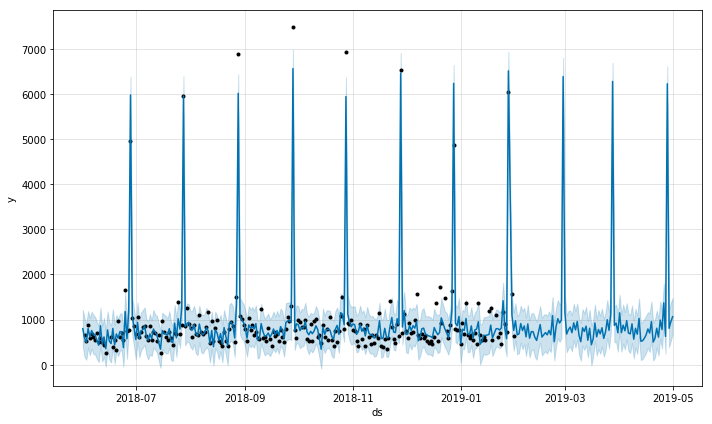

In [23]:
fig1 = m.plot(forecast)